In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
import warnings
import math
import time
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_breast_cancer, load_digits, fetch_openml, load_iris, make_moons, make_blobs
from sklearn.linear_model import LogisticRegression, LogisticRegression
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline

# Curse of dimensionality

https://en.wikipedia.org/wiki/Curse_of_dimensionality

Zbyt duża ilość cech w modelu prowadzi do overfittingu, nasz model będzie uczył się danych na pamięć. Dodatkowo, chcemy otrzymać w miarę prosty model, co jest niemożliwe w przypadku dyżej ilości cech.

In [2]:
cancer = load_breast_cancer()
X, y = (cancer.data, cancer.target)

num_feats = 4

X = MinMaxScaler().fit_transform(X)
X

array([[0.52103744, 0.0226581 , 0.54598853, ..., 0.91202749, 0.59846245,
        0.41886396],
       [0.64314449, 0.27257355, 0.61578329, ..., 0.63917526, 0.23358959,
        0.22287813],
       [0.60149557, 0.3902604 , 0.59574321, ..., 0.83505155, 0.40370589,
        0.21343303],
       ...,
       [0.45525108, 0.62123774, 0.44578813, ..., 0.48728522, 0.12872068,
        0.1519087 ],
       [0.64456434, 0.66351031, 0.66553797, ..., 0.91065292, 0.49714173,
        0.45231536],
       [0.03686876, 0.50152181, 0.02853984, ..., 0.        , 0.25744136,
        0.10068215]])

In [3]:
X.shape

(569, 30)

30 cech to za dużo - trzeba zredukować ich liczbę. Służą do tego gotowe algorytmy

# Procedury selekcji cech

### SFS - SequentialFeatureSelector

Sekwencyjny zachłanny algorytm dostępny w dwóch wersjach, Forward i Backward

In [4]:
knn = KNeighborsClassifier(n_neighbors=4)
num_feats = 4
features = pd.DataFrame(cancer.feature_names, columns=["Cechy"])

In [5]:
sfsForward = SFS(knn, k_features=num_feats, forward=True, n_jobs=-1)
sfsForward = sfsForward.fit(X, y)

features["SFSForward"] = [True if i in sfsForward.k_feature_idx_ else False for i in range(X.shape[1])]
sfsForward.k_feature_idx_

(7, 20, 21, 28)

In [6]:
X_features = sfsForward.fit_transform(X, y)
X_features

array([[0.73111332, 0.62077552, 0.14152452, 0.59846245],
       [0.34875746, 0.60690146, 0.30357143, 0.23358959],
       [0.63568588, 0.55638563, 0.36007463, 0.40370589],
       ...,
       [0.26351889, 0.39309854, 0.58901919, 0.12872068],
       [0.7554672 , 0.63358236, 0.73027719, 0.49714173],
       [0.        , 0.05428673, 0.48907249, 0.25744136]])

In [7]:
sfsBackward = SFS(knn, k_features=num_feats, forward=False, n_jobs=-1)
sfsBackward = sfsBackward.fit(X, y)

features["SFSBackward"] = [True if i in sfsBackward.k_feature_idx_ else False for i in range(X.shape[1])]
sfsBackward.k_feature_idx_

(6, 20, 21, 24)

In [8]:
sfsBackward.fit_transform(X,y)

array([[0.70313964, 0.62077552, 0.14152452, 0.60113584],
       [0.20360825, 0.60690146, 0.30357143, 0.34755332],
       [0.46251172, 0.55638563, 0.36007463, 0.48358978],
       ...,
       [0.21675258, 0.39309854, 0.58901919, 0.28217658],
       [0.82333646, 0.63358236, 0.73027719, 0.61962623],
       [0.        , 0.05428673, 0.48907249, 0.12408374]])

### RFE - Recursive Feature Elimination

Rekurencyjna eliminacja cech
Rekurencyjnie usuwane sa najmniej znaczące cechy, aż do uzyskania zdefiniowanej przez nas liczby cech.

Z dokumentacji sklearn:

Celem rekurencyjnej eliminacji cech (RFE) jest selekcja poprzez rekurencyjne uwzględnianie coraz mniejszych zestawów atrybutów. Najpierw estymator jest szkolony na początkowym zestawie atrybutów, a znaczenie każdego z nich uzyskiwane jest albo przez atrybut coef_ lub poprzez atrybut featureimportance. Następnie, najmniej ważne atrybuty są usuwane z bieżącego zestawu. Tę procedurę powtarza się rekurencyjnie, aż w końcu zostanie osiągnięta potrzebna nam ilość atrybutów do wyboru.

In [9]:
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
features["RFE"] = rfe_support

## Podsumowanie

In [10]:
if "Total" in features.columns:
    features = features.drop(columns="Total")
features['Total'] = np.sum(features, axis=1)
# display the top 100
features = features.sort_values(['Total','Cechy'] , ascending=False)
features.index = range(1, len(features)+1)
features

,Cechy,SFSForward,SFSBackward,RFE,Total
1,worst radius,True,True,True,3
2,worst texture,True,True,False,2
3,mean concave points,True,False,True,2
4,worst symmetry,True,False,False,1
5,worst smoothness,False,True,False,1
6,worst perimeter,False,False,True,1
7,worst concave points,False,False,True,1
8,mean concavity,False,True,False,1
9,worst fractal dimension,False,False,False,0
10,worst concavity,False,False,False,0


# Przykład dla zestawu z 64 cechami
Zestaw zawiera obrazki 8x8, za pomocą powyższych algorytmów sprawdzimy, które piksele mają największy wpływ na rozpoznanie cyfry na obrazku.

In [11]:
def plot_img(data):
    data = [i for i in data]
    img = np.zeros((8,8), dtype=float)
    for x in range(8):
        for y in range(8):
            img[y][x]=data[y*8+x]
    plt.imshow(img)

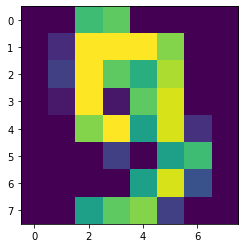

In [12]:
digits = load_digits()
X_digits, y_digits = (digits.data, digits.target)

X_digits = MinMaxScaler().fit_transform(X_digits)

plot_img(X_digits[9])

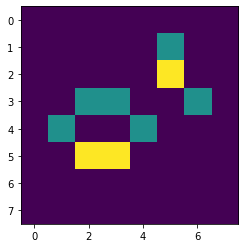

In [13]:
features = pd.DataFrame({"Px no." : [str(i) for i in range(64)]})
knn = KNeighborsClassifier(n_neighbors=4)
num_feats = 4

sfsForward = SFS(knn, k_features=num_feats, forward=True, n_jobs=-1)
sfsForward = sfsForward.fit(X_digits, y_digits)
features["SFSForward"] = [True if i in sfsForward.k_feature_idx_ else False for i in range(X_digits.shape[1])]

sfsBackward = SFS(knn, k_features=num_feats, forward=False, n_jobs=-1)
sfsBackward = sfsBackward.fit(X_digits, y_digits)
features["SFSBackward"] = [True if i in sfsBackward.k_feature_idx_ else False for i in range(X_digits.shape[1])]

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=100)
rfe_selector.fit(X_digits, y_digits)
rfe_support = rfe_selector.get_support()
features["RFE"] = rfe_support

if "Total" in features.columns:
    features = features.drop(columns="Total")
features['Total'] = np.sum(features, axis=1)
features.index = range(1, len(features)+1)
plot_img(features['Total'])

Pokazane piksele, które mają największe znaczenie przy klasyfikacji

### Porównanie skuteczności klasyfkacji z wszystkimi cechami i po zmniejszeniu ilości cech

In [14]:
def check_knn_accuracy(X_train, X_test, y_train, y_test, k, weights='uniform'):
    knn = KNeighborsClassifier(k, weights)
    knn.fit(X_train, y_train)
    y_predicted = knn.predict(X_test)
    return accuracy_score(y_test, y_predicted)

In [15]:
def pick_random_features(X, num_feats):
    X_random = []
    random_feats = random.choices(list(range(X.shape[1])), k=num_feats)
    
    for x in X:
        X_random.append([x[i] for i in random_feats])
    
    return np.asarray(X_random)

In [16]:
def get_accuracy_list(X, y):
    accuracy_list = []
    for k in [1,3,5]:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, 
                                                            test_size=0.3, random_state = 42)
        accuracy_list.append(check_knn_accuracy(X_train, X_test, y_train, y_test, k))
    return accuracy_list

In [17]:
accuracy_2_features = pd.DataFrame({'k': ["1", "3", "5"]})
accuracy_5_features = pd.DataFrame({'k': ["1", "3", "5"]})

In [18]:
cancer = load_breast_cancer()
X, y = (cancer.data, cancer.target)

X = MinMaxScaler().fit_transform(X)

accuracy_2_features["Wszystkie"] = get_accuracy_list(X, y)
accuracy_5_features["Wszystkie"] = get_accuracy_list(X, y)

In [19]:
# Uzupełnij kod, aby wybierał losowe cechy z X. Użyj funkcji pick_random_features
# X_random_features = 
# accuracy_2_features["Losowe"] = get_accuracy_list(X_random_features, y)

In [20]:
# Uzupełnij kod, aby wybierał najważniejsze cechy z X. Użyj SelectKBest i fit_transform
# 
# X_reduced_features = 
# accuracy_2_features["Wybrane"] = get_accuracy_list(X_reduced_features, y)

In [21]:
accuracy_2_features

,k,Wszystkie
0,1,0.959064
1,3,0.970760
2,5,0.964912


In [22]:
accuracy_5_features

,k,Wszystkie
0,1,0.959064
1,3,0.970760
2,5,0.964912


## Macierz kowariancji

Wariancja - miara zmienności, średnia arytmetyczna różnic między wartością otrzymana a oczekiwaną.  
Kowariancja - liczba określająca zależność liniową między zmiennymi losowymi.  
Macierz kowariancji – uogólnienie pojęcia wariancji na przypadek wielowymiarowy.

<img src="./img/ad6_1.png">

#### Przykład  
Mamy daną tablię ocen studentów

<img src="./img/ad6_2.png">

Tworzymy macierz  
<img src="./img/ad6_3.png">
a następnie korzystajac z wzoru

<img src="./img/ad6_4.png">

<img src="./img/ad6_5.png">

<img src="./img/ad6_6.png">

<img src="./img/ad6_7.png">

<img src="./img/ad6_8.png">

### Obliczanie macierzy kowariancji w numpy

In [23]:
X = np.array([4,2,.6,4.2,2.1,.59,3.9,2,.58,4.3,2.1,.62,4.1,2.2,.63]).reshape(5,3)

print("Macierz kowariancji obliczana przy pomocy numpy:")
print(np.cov(X))

print("Macierz kowariancji obliczana tradycyjną metodą")
mean = np.mean(X, 0)
print(np.dot(X - mean,(X - mean).T)/(5-1))

Macierz kowariancji obliczana przy pomocy numpy:
[[2.92       3.098      2.846      3.164      2.966     ]
 [3.098      3.28703333 3.0199     3.3566     3.1479    ]
 [2.846      3.0199     2.7748     3.0832     2.8933    ]
 [3.164      3.3566     3.0832     3.4288     3.2122    ]
 [2.966      3.1479     2.8933     3.2122     3.0193    ]]
Macierz kowariancji obliczana tradycyjną metodą
[[ 0.004104 -0.002886  0.006624 -0.005416 -0.002426]
 [-0.002886  0.002649 -0.005316  0.005044  0.000509]
 [ 0.006624 -0.005316  0.011744 -0.010496 -0.002556]
 [-0.005416  0.005044 -0.010496  0.010164  0.000704]
 [-0.002426  0.000509 -0.002556  0.000704  0.003769]]


Różnica wynika z faktu, że np.cov oblicza kowariancję między wektorami wierszowymi, dlatego wynik jest 5*5 zamiast 3*3, ale np.mean oblicza średnią wektorów kolumn i kiedy to robisz test - mean obliczenia są również transmitowane wzdłuż kolumny, która różni się od tego np.cov robi, poprawka byłaby dwuetapowa:

Po pierwsze, upewnij się, że średnia jest obliczana dla każdego wiersza, co można zrobić po prostu transponując test matryca:

In [24]:
mean = np.mean(X.T, 0)

A następnie, gdy obliczyć x - x_bar, przekształć wektor średni tak, aby minus był również wzdłuż rzędów, a także, ponieważ wektor będący w teście jest wektorem rzędu, wymiar będzie 3 zamiast 5. Po tych naprawach uzyska spójne wyniki np.cov robi:

In [25]:
print(np.dot(X - mean[:, None], (X - mean[:, None]).T)/(3-1))

[[2.92       3.098      2.846      3.164      2.966     ]
 [3.098      3.28703333 3.0199     3.3566     3.1479    ]
 [2.846      3.0199     2.7748     3.0832     2.8933    ]
 [3.164      3.3566     3.0832     3.4288     3.2122    ]
 [2.966      3.1479     2.8933     3.2122     3.0193    ]]


### HotMap
Narzędzie urzywane do redukcji cech ze zbioru danych, pozwala wyodrębnić te cechy które są w wysokiej korelacji

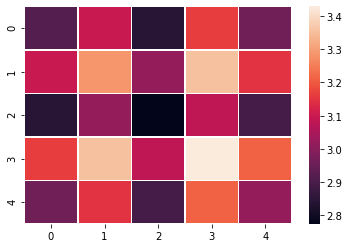

In [26]:
ax = sns.heatmap(np.cov(X), linewidth=0.5)
plt.show()

# PCA - Principal Component Analysis

PCA - Analiza głównych składowych polega na takim przeksztalceniu ramki odniesienia (układu współzednych) aby pierwszy element wektorów danych posiadał największą wariancje. To znaczy najwiekszy wplyw na zmiennosc danych ma pierwsza zmienna. Pozwala to np. pominąć część dalszych elementów wektora bez dużej straty dokladnosci, zyskując potencjalnie na wydajnosci algorytmu.


## Przygotowanie danych

Aby użyc transformacji PCA z scikitlearn-a należy najpierw przeksztalcic zbior danych do postaci w ktorej srednia wartosc wynosi 0 a wariancja wynosi .

Skorzystamy przy tym ze StandardScaler-a ktory przeprowadza dokladnie ta operacje na zbiorze danych

```data = StandardScaler().fit_transform(data)```

## Wykonanie transformacji
Tworzymy instancje algorytmu PCA. Mozemy wybrac czy interesuje nas konkretna ilosc wymiarów czy tez zadamy zachowania konkretnej wariancji 

``` pca = PCA(n_components=2)   # 2 wymairy po transformacji ```

``` pca = PCA(0.95)             # wariancja na poziomie przynajmniej 0.95  ```



Nastepnie nalezy na podstawie danych wybrac wektory bazowe nowej przestrzeni.

Baza ktora nas interesuje jest bazą własną macierzy kowariancji zmiennych w orginalnej przestrzeni

``` pca.fit(data) ```


Kolejnym krokiem jest transformacja danych w bazie zrodlowej do bazy wyznaczonej  poprzednio.

``` data = pca.transform(data) ```

## Wizualizja daych wielowymiarowych
   PCA poprzez zmniejszenie wymiarowosci danych pozwala zredukowac data set do postaci 2 lub 3 wymiarowej którą mozna wyświetlić 
   Wizualizacja na przykładzie zbioru danych Iris jest prezętowana na przykładzie w puźniejszej części poniżej.

## Przyśpieszenie działania algorymow poprzez zmniejszenie wymiarowośći

In [27]:
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)

In [28]:
train_X, test_X, train_Y, test_Y = train_test_split( fmnist.data, fmnist.target, test_size=0.02, train_size = 0.1, random_state=42)

In [29]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_X)

# Apply transform to both the training set and the test set.
train_X2 = scaler.transform(train_X)
test_X2 = scaler.transform(test_X)

In [30]:
from sklearn.decomposition import PCA

pca = PCA(2)

pca.fit(train_X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [31]:
print (len(pca.explained_variance_ratio_), pca.explained_variance_ratio_.sum())

2 0.474167204610982


In [32]:
train_X3 = pca.transform(train_X2)
test_X3 = pca.transform(test_X2) 

In [33]:
#Po przeksztalceniach liczba wymiarow powina spasc

print (len(train_X[0]), len(train_X3[0]))

784 2


In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score

def check_accuracy_knn(X_train, X_test, y_train, y_test, n_neighbors=5, weights='uniform'):
    knn = KNeighborsClassifier(n_neighbors, weights)
    knn.fit(X_train, y_train)
    y_predicted = knn.predict(X_test)
    return accuracy_score(y_test, y_predicted)

In [35]:
import time

start = time.time()
acc = check_accuracy_knn(train_X, test_X, train_Y, test_Y)
end = time.time()

print("Time: {}, Normal accuracy: {}".format(end - start, acc))


Time: 11.574044227600098, Normal accuracy: 0.81


In [36]:
start = time.time()
acc = check_accuracy_knn(train_X3, test_X3, train_Y, test_Y)
end = time.time()

print("Time: {}, PCA accuracy: {}".format(end - start, acc))

Time: 0.04883694648742676, PCA accuracy: 0.5107142857142857


Jak widac w powyzszym przykladzie udalo nam znacznie przyspieszyc wykonywanie algorytmu, jednoczesnie nie pogarszajac dokladnosci

### Dopasowanie klasyfikatorów knn w dla orginalnego zestawu cech i uproszczonego

Poniższe wykresy prezentują zależność jakości dopasowania od ilości cech i liczby wybrancyh sąsiadów dla klasyfikatora knn. Warto zwrócić szczególnie uwagę na czas w jakim poszczególny klasyfikator dokonuje selekcji w zależności od ilości cech w dany zbiorze danych

In [37]:
def check_accuracy_knn(X_train, X_test, y_train, y_test, n_neighbors=5, weights='uniform'):
    knn = KNeighborsClassifier(n_neighbors, weights)
    knn.fit(X_train, y_train)
    y_predicted = knn.predict(X_test)
    return accuracy_score(y_test, y_predicted)

def pca_transform_dataset(X_train, X_test, n):
    scaler = StandardScaler()
    pca = PCA(n)

    scaler.fit(X_train)
    train_X2 = scaler.transform(X_train)
    test_X2 = scaler.transform(X_test)

    pca.fit(X_train)
    train_X3 = pca.transform(train_X2)
    test_X3 = pca.transform(test_X2)
    
    return train_X3, test_X3

In [38]:
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)
X_train, X_test, y_train, y_test = train_test_split( fmnist.data, fmnist.target, test_size=0.02, train_size = 0.1, random_state=42)

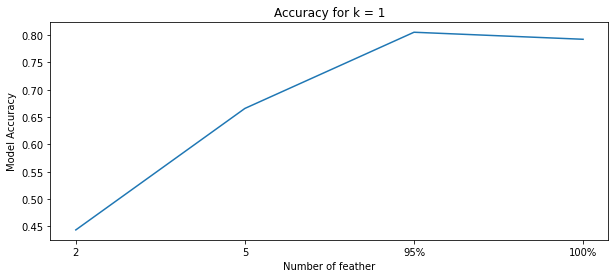

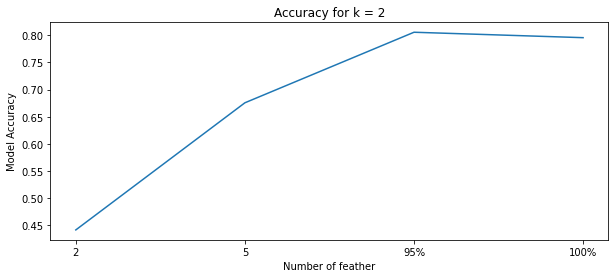

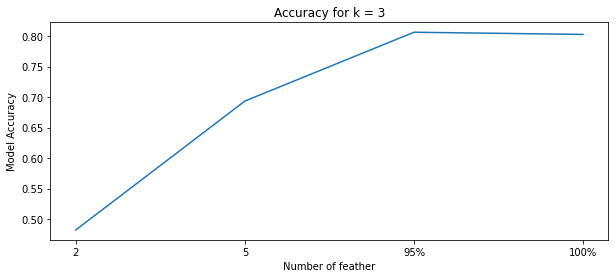

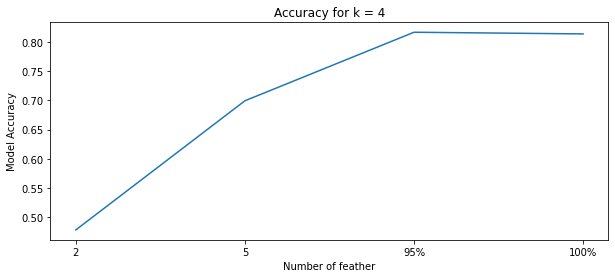

,k,n,accuracy,feather_count,time
0,1,2,0.443571,2,0.104742
1,1,5,0.665714,5,0.115931
2,1,0.95,0.805000,179,0.972415
3,1,100%,0.792143,784,11.378594
4,2,2,0.441429,2,0.107475
5,2,5,0.675714,5,0.115326
6,2,0.95,0.805714,179,1.035651
7,2,100%,0.795714,784,11.190945
8,3,2,0.482143,2,0.121963
9,3,5,0.693571,5,0.119792


In [39]:
measurements_data = []

for k in [1, 2, 3, 4]:
    measurements_data_single = []
    for n in [2, 5, .95]:
        # on transform data set
        X_train_transform, X_test_transform = pca_transform_dataset(X_train, X_test, n)
        start = time.time()
        accuracy = check_accuracy_knn(X_train_transform, X_test_transform, y_train, y_test, k)
        end = time.time()
        feather_count = len(X_train_transform[0])
        measurements_data.append([k, n, accuracy, feather_count, (end - start)])
        measurements_data_single.append(accuracy)
        
    # on original dataset
    start = time.time()
    accuracy = check_accuracy_knn(X_train, X_test, y_train, y_test, k)
    end = time.time()
    feather_count = len(X_train[0])
    measurements_data.append([k, "100%", accuracy, feather_count, (end - start)])
    measurements_data_single.append(accuracy)
    
    plt.figure(figsize = (10, 4)) 
    plt.plot(["2", "5", "95%", "100%"], measurements_data_single) 
    plt.title(f"Accuracy for k = {k}")
    plt.xlabel('Number of feather') 
    plt.ylabel('Model Accuracy') 
    plt.show()
    
pd.DataFrame(measurements_data, columns=["k", "n", "accuracy", "feather_count", "time"])

### Prezętacja danych 2D przy pomocy PCA dla zbioru Iris

Przygotowanie zbioru danych

In [40]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(filepath_or_buffer=url, header=None, sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']  
df.dropna(how="all", inplace=True)
df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [41]:
data = df.iloc[:,0:4].values 
labels = df.iloc[:,4].values

Wykonanie PCA na zbiorze danych

In [42]:
data = StandardScaler().fit_transform(data)

pca = PCA(n_components=2)
pc = pca.fit_transform(data)
pc_df = pd.DataFrame(data = pc, columns =['PC 1', 'PC 2'])

result_df = pd.concat([pc_df, df.iloc[:,4]], axis = 1)

Wizualizacja wyniku

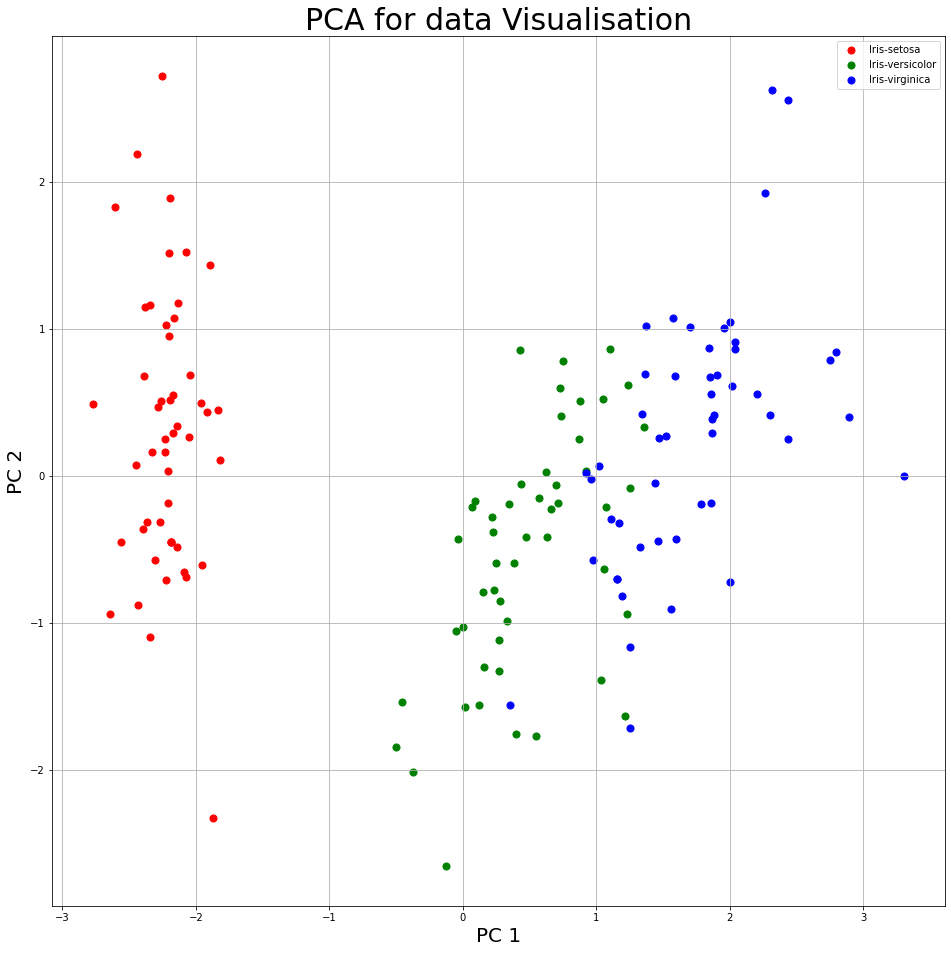

In [43]:
fig = plt.figure( figsize = (16,16))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC 1', fontsize = 20)
ax.set_ylabel('PC 2', fontsize = 20)
ax.set_title('PCA for data Visualisation', fontsize = 30)

targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = result_df['class'] == target
    ax.scatter(result_df.loc[indicesToKeep, 'PC 1']
               , result_df.loc[indicesToKeep, 'PC 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Narzędza do wykrywania anomalii i outlinerów

Narzędzia do wykrywania outlinweów moga ułatwiać pracę podczas diagnozowania anomali. Poniższy przyklad przedstawia działąnie różnych algorytmów słóżących do detekcji takich anomalii.

Ustawienie parametrów

In [44]:
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

Zdefiniowanie metod to wykrywania animali(outlinerów)

In [45]:
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction, random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction))
]

Zdefiniowanie zbiorów danych

In [46]:
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3], **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] - np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)
]

Porównanie wyników dla poszczególnych metod

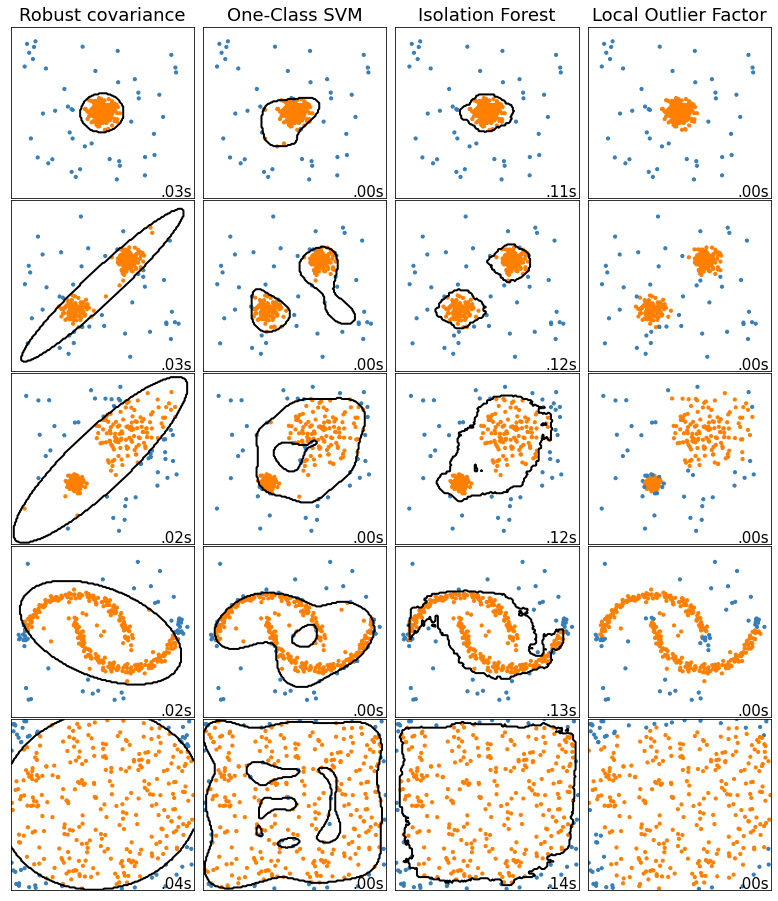

In [47]:
# Dodatkowe ustawienia wyświetlania wyniku
plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
plot_num = 1
rng = np.random.RandomState(42)
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

for i_dataset, X in enumerate(datasets):

    # zaznaczenie granic
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # dopasowanie do zbioru danych
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plotowanie wyników
        if name != "Local Outlier Factor":  # LOF nie implementuje predykcji
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7); plt.ylim(-7, 7)
        plt.xticks(()); plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'), 
                 transform=plt.gca().transAxes, size=15, horizontalalignment='right')
        plot_num += 1

plt.show()

## Zadanie do samodzielnego wykonania

Będziemy operować na części zbioru MNIST, więc go pobieramy i losowo wybieramy 1000 elementów

In [48]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

In [49]:
mnist.data.shape

(70000, 784)

In [50]:
mnist_zipped = list(zip(mnist.data, mnist.target))
mnist_random_sample = random.sample(mnist_zipped, 1000)
X, Y = zip(*(mnist_random_sample))
X = np.asarray(X)
Y = np.asarray(Y)
X.shape

(1000, 784)

Teraz znajdź najmniej informatywne cechy (piksele) i zobrazuj je na rysunku.
Możesz w tym celu użyć funkcji SFS (należy wybrać NAJMNIEJ informatywne cechy)

In [51]:
#
#
#

Dokonaj klasyfikacji k-nn na pełnym zbiorze i zbiorze bez m najmniej informatywnych cech. m = 100,200,500

In [52]:
#
#
#

Przetransformować zbiory przy pomocy PCA z N-D do N-D. Jak wyglądają (obrazki)
wektory własne odpowiadające największym wartością własnym. Sprawdzić, czy
poprawił się wynik klasyfikacji. Dokonać wizualizacji 2-D przy pomocy PCA.

In [53]:
#
#
#

Usunąć m najmniej informatywnych cech PCA. Jak wygląda wynik klasyfikacji.

In [54]:
#
#
#

Wybrac m NAJLEPSZYCH cech PCA. Jak wygląda teraz wynik klasyfikacji.

In [55]:
#
#
#

Wartość m w przypadku wyboru najgorszych cech ma być duże (dla N=784 jakieś m=500), w przypadku wyboru najlepszych małe (m=10-20)

In [56]:
#
#
#

Dokonać klasyfikacji z PCA i bez PCA (na pełnym zbiorze cech i zadanym małym M), ale zwiększając ilość przykładów przy pomocy augmentacji (imgaug).

In [57]:
#
#
#

Wnioski (co lepsze augmentacja czy inżynieria cech?)

In [58]:
#
#
#